In [3]:
import os
import csv
import time
import random
from pathlib import Path

import numpy as np
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from PIL import ImageEnhance

from dropblock import DropBlock
# coding: utf-8

%matplotlib inline

In [4]:
def register_extension(id, extension):
    Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions):
    for extension in extensions:
        register_extension(id, extension)
Image.register_extensions = register_extensions

In [5]:
class Net(nn.Module):
 
    def __init__(self, n_channels, n_classes):
        super(Net, self).__init__()
        
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        self.conv1 = nn.Conv2d(self.n_channels, 16, kernel_size=3, stride=1, padding=1)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        
        self.fc1 = nn.Linear(128*4*4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, self.n_classes)
        
        self.relu = nn.ReLU()
        self.drop = DropBlock(0.95, 3)
        #self.drop = torch.nn.Dropout2d(0.2)
    def forward(self, x):
        
        x = self.relu(self.conv1(x))
        x = self.drop(self.relu(self.conv2(x)))
        x = self.drop(self.relu(self.conv3(x)))
        x = self.drop(self.relu(self.conv4(x)))
        x = x.view(-1, 128*4*4)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        #x = F.softmax(x,dim=1)

        return x

In [6]:
class Model():
    def __init__(self, n_ch=3, n_class=10, height=32, width=32):
      
        self.total_epoch_num = 0
        self.train_progress_report_epoch = 5
        self.net = Net(n_channels=n_ch, n_classes=n_class)
        #self.opt_net= torch.optim.SGD(self.net.parameters(), lr=0.01, momentum=0.9)
        self.opt_net= torch.optim.RMSprop(self.net.parameters(),lr=0.00002)
        self.criterion = torch.nn.CrossEntropyLoss()

    def train(self,
              epochs=10,
              batch_size=24,
              steps=50,
              trainset=None,
              save_weight_path='./save_weights',
              loss_report_file='./loss_report.csv',
              init=False,
              use_gpu=False):
        
        train_generator = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                  shuffle=True, num_workers=2)
        
        save_weight_dir = Path(save_weight_path)
        if not (save_weight_dir.is_dir()):
            save_weight_dir.mkdir()
            print("create save param directory : {0}".format(
                str(save_weight_dir)))
            
        save_net_weight_path = save_weight_dir / 'current_params.pth'
        
        if(init or os.path.exists(loss_report_file)==False):
            header = ['epoch', 'loss']
            with open(loss_report_file, 'w') as f:
                writer = csv.writer(f)
                writer.writerow(header)
            del header
            print("create and initialize loss report csv file")
            
        if(use_gpu):
            print("use gpu")
            self.net.cuda()
            self.criterion.cuda()
        
        total_net_loss = 0.0
        
        for epoch in range(epochs):
            
            total_net_loss = 0.0         
            start_time = time.time()
            self.net.train()
            for i, data in enumerate(train_generator, 1):
                  
                X_train, t_train = data

                if(use_gpu):
                    X_train = Variable(X_train.cuda())
                    t_train = Variable(t_train.cuda())
                
                net_output = self.net(X_train)
                loss = self.criterion(net_output, t_train)              
                total_net_loss += loss.item()
                
                self.opt_net.zero_grad()
                loss.backward()
                self.opt_net.step()
                
                if(i % steps == 0):
                    break
            # 1epoch finished
            end_time = time.time()
            self.total_epoch_num += 1
            total_net_loss = total_net_loss / steps

            print(
                "[Train] epoch: %d, net loss : %f, time : %f" %
                (self.total_epoch_num, total_net_loss, end_time - start_time))

            # epoch_num, net_loss
            body = [self.total_epoch_num, total_net_loss]
            with open(loss_report_file, 'a') as f:
                writer = csv.writer(f)
                writer.writerow(body)

            torch.save(self.net.state_dict(),  str(save_net_weight_path))

In [7]:
n_class=10

In [8]:
model = Model(n_ch=3, n_class=n_class, height=32, width=32)

In [9]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomHorizontalFlip(p=0.5), 
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [10]:
use_gpu = torch.cuda.is_available()

batch_size = 100
model_title = './cifar10_dropblock'

model.train(epochs=21,
              batch_size=batch_size,
              steps = 100,
              trainset=trainset,
              save_weight_path=model_title,
              loss_report_file=model_title+'_loss_report.csv',
              init=True,
              use_gpu=use_gpu)

create and initialize loss report csv file
use gpu
[Train] epoch: 1, net loss : 2.266700, time : 319.035692
[Train] epoch: 2, net loss : 2.183351, time : 318.996005
[Train] epoch: 3, net loss : 2.148362, time : 317.595471
[Train] epoch: 4, net loss : 2.102828, time : 315.740752
[Train] epoch: 5, net loss : 2.064880, time : 314.524529
[Train] epoch: 6, net loss : 2.048798, time : 315.625168
[Train] epoch: 7, net loss : 2.018481, time : 315.965008
[Train] epoch: 8, net loss : 2.004719, time : 315.085694
[Train] epoch: 9, net loss : 1.985057, time : 316.717504
[Train] epoch: 10, net loss : 1.978189, time : 316.884434
[Train] epoch: 11, net loss : 1.986049, time : 315.326426
[Train] epoch: 12, net loss : 1.968562, time : 313.465202
[Train] epoch: 13, net loss : 1.960076, time : 315.250741
[Train] epoch: 14, net loss : 1.940040, time : 315.127882
[Train] epoch: 15, net loss : 1.934926, time : 319.454784
[Train] epoch: 16, net loss : 1.939206, time : 318.075388
[Train] epoch: 17, net loss : 

In [28]:
use_gpu = torch.cuda.is_available()

model.net.load_state_dict(torch.load('./cifar10_dropblock/current_params.pth'))
model.net.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
  (drop): DropBlock()
)

In [29]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_generator = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [ ]:
correct = 0
total = 0
model.net.eval()
with torch.no_grad():
    for data in test_generator:
        images, labels = data
        if(use_gpu):
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        outputs = model.net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

In [0]:
dataiter = iter(test_generator)
images, labels = dataiter.next()
if(use_gpu):
    images = Variable(images.cuda())
    labels = Variable(labels.cuda())

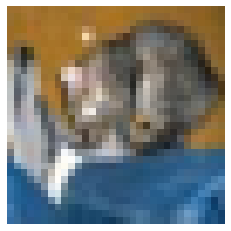

In [42]:
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
plt.grid(False)
plt.imshow(images[0,:,:,:].cpu().detach().numpy().transpose(1,2,0) / 2 + 0.5 )

In [ ]:
model.net.train()

In [0]:
x = model.net.relu(model.net.conv1(images))

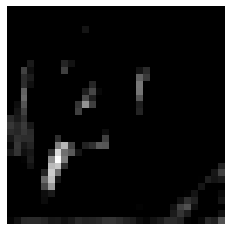

In [45]:
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
plt.grid(False)
plt.imshow(x[0,0,:,:].cpu().detach().numpy(),'gray')

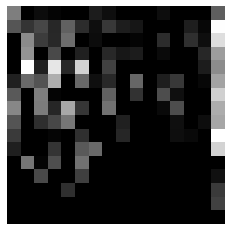

In [46]:
x2 = model.net.relu(model.net.conv2(x))

plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
plt.grid(False)
plt.imshow(x2[0,0,:,:].cpu().detach().numpy(),'gray')

In [0]:
model.net.drop.keep_prob = 0.75
model.net.drop.block_size = 3

x2_dropout = model.net.drop(x2)

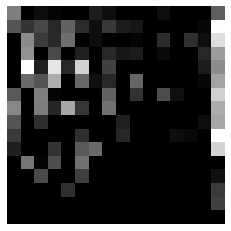

In [48]:
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
plt.grid(False)
plt.imshow(x2_dropout[0,0,:,:].cpu().detach().numpy(),'gray')

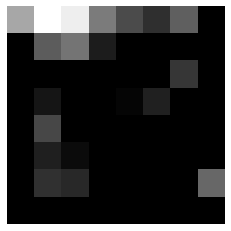

In [49]:
x3 = model.net.relu(model.net.conv3(x2_dropout))

plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
plt.grid(False)
plt.imshow(x3[0,0,:,:].cpu().detach().numpy(),'gray')

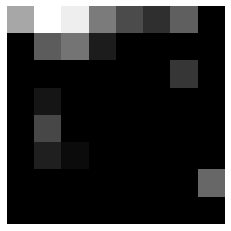

In [50]:
x3_dropout = model.net.drop(x3)

plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
plt.grid(False)
plt.imshow(x3_dropout[0,0,:,:].cpu().detach().numpy(),'gray')

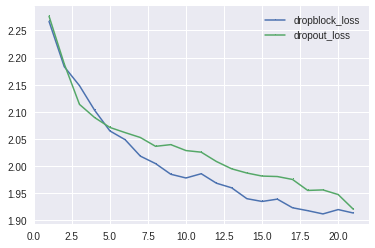

In [15]:
import pandas as pd
df = pd.read_csv('./cifar10_dropblock_loss_report.csv', header=0)
col = df.columns
plt.plot(df[col[0]],df[col[1]],'-,',label='dropblock_loss', linewidth=1.5)

df = pd.read_csv('./cifar10_dropout_loss_report.csv', header=0)
col = df.columns
plt.plot(df[col[0]],df[col[1]],'-,',label='dropout_loss', linewidth=1.5)

plt.legend()
plt.show()
plt.close()